<a href="https://colab.research.google.com/github/RonaldCedeno/Face-Mask-Detection/blob/main/Face_Mask_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Images - Dataset

In [ ]:
# Images are downloaded from the following repository, 
# thanks to the owner for using the images and 
# giving an understanding of the codebase
!git clone https://github.com/balajisrinivas/Face-Mask-Detection

Cloning into 'Face-Mask-Detection'...
remote: Enumerating objects: 3767, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 3767 (delta 0), reused 0 (delta 0), pack-reused 3764
Receiving objects: 100% (3767/3767), 143.05 MiB | 42.89 MiB/s, done.
Resolving deltas: 100% (2/2), done.


# Data review

In [ ]:
DATASET = '/content/Face-Mask-Detection/dataset'

In [ ]:
from pathlib import Path

In [ ]:
mask = list(Path(DATASET).glob('with_mask/*'))
no_mask = list(Path(DATASET).glob('without_mask/*'))

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
img_test = cv2.imread(str(mask[100]), 1)
img_test = cv2.resize(img_test, (224, 224))

In [ ]:
img_test.shape

(224, 224, 3)

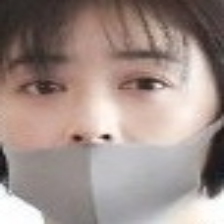

In [ ]:
cv2_imshow(img_test)

# Classes

In [ ]:
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
class Dataset():

  def __init__(
      self,
      train_val_test,
      split_percentage
  ): 
    self.train_val_test = train_val_test
    self.split_percentage = split_percentage
    self.call_exceptions()

    self.mask_limit = [round(len(mask)*(p/100)) 
                      for p in split_percentage]

    self.no_mask_limit = [round(len(no_mask)*(p/100))
                          for p in split_percentage]
    
    # self.data = np.random.permutation(self.creating_dataset())
    self.data = self.creating_dataset()
    

  def __len__(self):
    return len(self.data)


  def __getitem__(self, i):
    img = cv2.imread(str(self.data[i][0]), 1)
    img = cv2.resize(img, (224, 224))
    img = preprocess_input(img)

    return img, self.data[i][1]


  def call_exceptions(self):
    if type(self.split_percentage) != tuple:
      raise Exception("Split percentage must be a tuple of 2 or 3 values")

    if sum(self.split_percentage) != 100:
      raise Exception('Total percentage must sum 100%')


  def creating_dataset(self):

    m0, m1 = self.mask_limit[0], self.mask_limit[1]
    nm0, nm1 = self.no_mask_limit[0], self.no_mask_limit[1]

    if self.train_val_test == 'train':
      data = (mask[:m0], no_mask[:nm0])

    elif self.train_val_test == 'val':
      data = (mask[m0:m0+m1], no_mask[nm0:nm0+nm1])

    elif self.train_val_test == 'test':
      data = (mask[m0+m1:], no_mask[nm0+nm1:])

    else:
      m = "Accepted values for train_val_test " \
          "could be 'train', 'val' or 'test'"
      raise Exception(m)
    
    label_mask = np.zeros(len(data[0]), dtype=int)
    label_no_mask = np.ones(len(data[1]), dtype=int)
    label = np.concatenate([label_mask,label_no_mask])
    data = data[0] + data[1]

    return list(zip(data, label))

In [ ]:
def denormalize_img(image):
  return np.round((image+1)*0.5*255).astype(int)

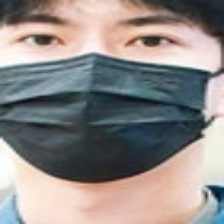

In [ ]:
ds = Dataset('train', (80,10,10))
cv2_imshow(denormalize_img(ds[0][0]))

In [ ]:
from tensorflow import keras

In [ ]:
class Dataloader(keras.utils.Sequence):

    def __init__(
          self, 
          dataset, 
          batch_size=1,
          shuffle=False
    ):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # Collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = [] # -> (image,label)
        for j in range(start, stop):
          idx = self.indexes[j]
          data.append(self.dataset[idx])

        # Creating list of arrays (2 elements in list)
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return [batch[0], np.expand_dims(batch[1], axis=1)]
    

    def __len__(self):
        # Denotes the number of batches per epoch
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        # Callback function to shuffle indexes each epoch
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
dl = Dataloader(ds, batch_size=3, shuffle=True)

# MobileNet

In [ ]:
from tensorflow.keras.applications import MobileNetV2

In [ ]:
base = MobileNetV2(weights="imagenet", 
                    include_top=False,
                    input_shape=(224,224,3),
                    input_tensor=keras.Input(shape=(224, 224, 3)))

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.utils import plot_model

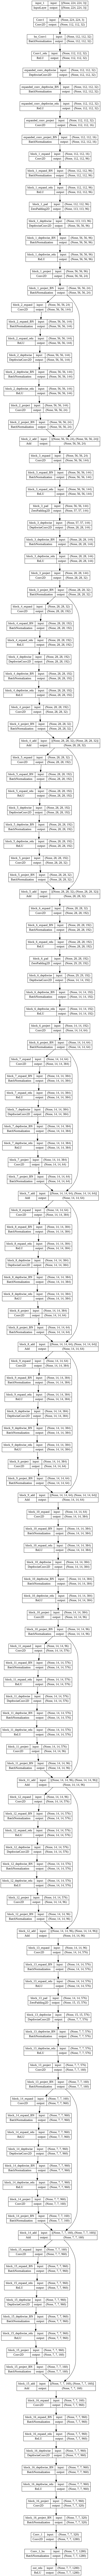

In [ ]:
plot_model(base, show_shapes=True)

In [ ]:
from tensorflow.keras import layers

In [ ]:
output = base.output
output = layers.AveragePooling2D(pool_size=(7, 7))(output)
output = layers.Flatten(name="flatten")(output)
output = layers.Dense(128, activation="relu")(output)
output = layers.Dropout(0.5)(output)
output = layers.Dense(1, activation="sigmoid")(output)

In [ ]:
model = keras.Model(inputs=base.input, outputs=output)

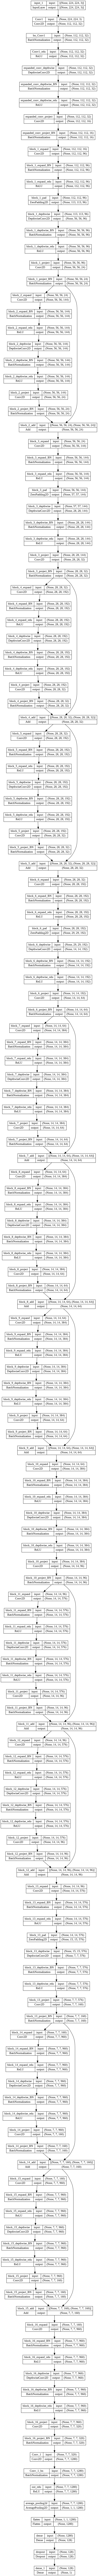

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
for layer in base.layers:
	layer.trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

# Model Training

In [ ]:
LR = 1e-4
EPOCHS = 30
BS = 32
SPLIT = (80,10,10)

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=LR, decay=LR/EPOCHS)

In [ ]:
model.compile(loss="binary_crossentropy", 
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
# Training Dataset
train_dataset = Dataset('train', SPLIT)

# Validation Dataset
val_dataset = Dataset('val',SPLIT)

In [ ]:
# Training Dataloader
train_dataloader = Dataloader(train_dataset, batch_size=BS, shuffle=True)

# Validation Dataloader
val_dataloader = Dataloader(val_dataset, batch_size=BS, shuffle=True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

In [ ]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=1, verbose=1, 
                             factor=0.2, min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy', min_delta=0, 
                           patience=5, verbose=1, mode='auto',
                           baseline=None, restore_best_weights=True)

# Saving best model
saving_model = ModelCheckpoint("best_model.h5", save_best_only=True)

In [ ]:
import tensorflow as tf

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(train_dataloader,
                      steps_per_epoch=len(train_dataloader),
                      epochs=EPOCHS,
                      validation_data=val_dataloader,
                      validation_steps=len(val_dataloader),
                      callbacks=[lr_decay, early_stop, saving_model])

Epoch 1/30
95/95 [==============================] - 25s 158ms/step - loss: 0.2908 - accuracy: 0.8806 - val_loss: 0.0814 - val_accuracy: 0.9844 - lr: 1.0000e-04
Epoch 2/30
95/95 [==============================] - 14s 150ms/step - loss: 0.1023 - accuracy: 0.9724 - val_loss: 0.0440 - val_accuracy: 0.9948 - lr: 1.0000e-04
Epoch 3/30
95/95 [==============================] - 14s 150ms/step - loss: 0.0749 - accuracy: 0.9786 - val_loss: 0.0311 - val_accuracy: 0.9896 - lr: 1.0000e-04
Epoch 4/30
95/95 [==============================] - 14s 150ms/step - loss: 0.0515 - accuracy: 0.9852 - val_loss: 0.0226 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 5/30
95/95 [==============================] - 14s 150ms/step - loss: 0.0438 - accuracy: 0.9872 - val_loss: 0.0186 - val_accuracy: 0.9974 - lr: 1.0000e-04
Epoch 6/30
95/95 [==============================] - 14s 148ms/step - loss: 0.0388 - accuracy: 0.9875 - val_loss: 0.0183 - val_accuracy: 0.9896 - lr: 1.0000e-04
Epoch 7/30
95/95 [======================

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

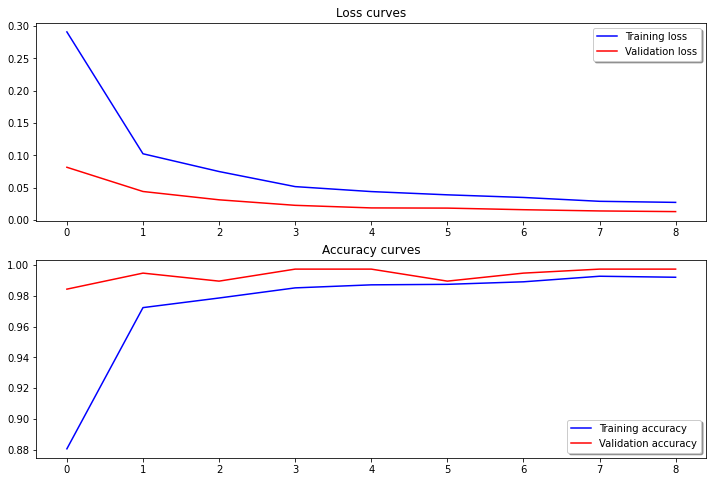

In [ ]:
# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,8))

axs[0].plot(history.history['loss'], color='b', label='Training loss')
axs[0].plot(history.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].legend(loc='best', shadow=True)

axs[1].plot(history.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].legend(loc='best', shadow=True)

plt.show()

# Model evaluation

In [ ]:
model.load_weights('best_model.h5')

In [ ]:
# Test Dataset
test_dataset = Dataset('test',SPLIT)

# Test Dataloader
test_dataloader = Dataloader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [ ]:
pred = model.predict(test_dataloader[0][0])
pred = np.where(pred>0.5, 1, 0)
pred = np.squeeze(pred, axis=1)

12/12 [==============================] - 2s 84ms/step


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
cf_matrix = confusion_matrix(test_dataloader[0][1].squeeze(axis=1), pred)

In [ ]:
np.unique(pred, return_counts=True)

(array([0, 1]), array([193, 190]))

In [ ]:
cf_matrix

array([[191,   0],
       [  2, 190]])

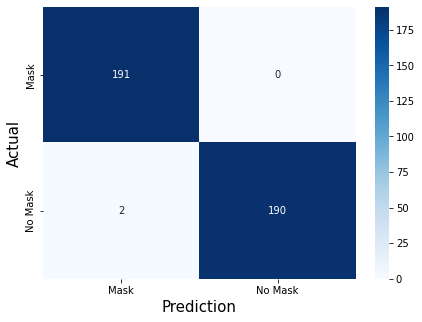

In [ ]:
labels = ['Mask','No Mask']
fig,ax = plt.subplots(figsize=(7,5))
_=sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
_=ax.set_xlabel("Prediction", fontsize = 15)
_=ax.set_ylabel("Actual", fontsize = 15)